# Notebook for Project 1

_Jonatan Haraldsson_ [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

_Jesper Noord_ [noord@chalmers.se](mailto:noord@chalmers.se)



In [2]:
# relevant modules for this notebook
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import emcee
import corner
import scipy
from scipy.stats import gamma, invgamma, t, norm, norminvgauss, mode, uniform
import seaborn as sns
import random
#import sklearn
import scipy.constants as const


# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size

c = const.speed_of_light *1e-3
G = const.gravitational_constant

np.random.seed(123)

**Importing the data from SCP 2.1 dataset and exploring data**

In [3]:
data_ = np.genfromtxt('SCPUnion2.1_mu_vs_z.txt')
df = pd.DataFrame(data_[:,1:5])  # only keep z, mu, mu_err
df.columns = ["z", "mu", "mu_err", "unknown"]


z = np.array(df['z'])
mu = np.array(df['mu'])
mu_err = np.array(df['mu_err'])
df.head()

,z,mu,mu_err,unknown
0,0.028488,35.346583,0.223906,0.128419
1,0.050043,36.682368,0.166829,0.128419
2,0.052926,36.817691,0.155756,0.128419
3,0.070086,37.446737,0.158467,0.128419
4,0.062668,37.483409,0.156099,0.128419


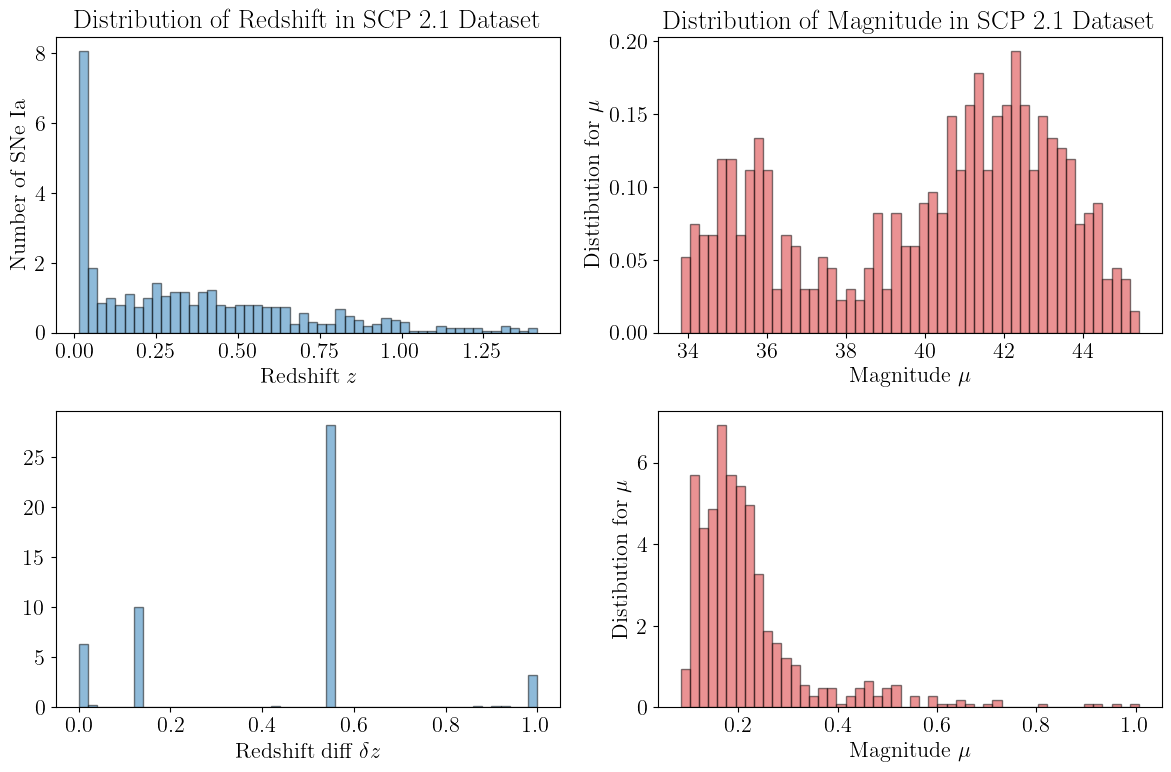

In [4]:
fig,ax = plt.subplots(2,2,figsize=(12,8))
ax[0,0].hist(z, bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[0,0].set_xlabel('Redshift $z$')
ax[0,0].set_ylabel('Number of SNe Ia')
ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[0,1].hist(mu, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')
ax[0,1].set_xlabel('Magnitude $\\mu$')
ax[0,1].set_ylabel('Disttibution for $\\mu$')
ax[0,1].set_title('Distribution of Magnitude in SCP 2.1 Dataset')


ax[1,0].hist(df['unknown'], bins=50,density=True,color='tab:blue',alpha=0.5,edgecolor='black')
ax[1,0].set_xlabel('Redshift diff $\\delta z$')
#ax[0,0].set_ylabel('Number of SNe Ia')
#ax[0,0].set_title('Distribution of Redshift in SCP 2.1 Dataset')
ax[1,1].hist(mu_err, bins=50,density=True,color='tab:red',alpha=0.5,edgecolor='black')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')
ax[1,1].set_xlabel('Magnitude $\\mu$')
ax[1,1].set_ylabel('Distibution for $\\mu$')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'All $z$ values')

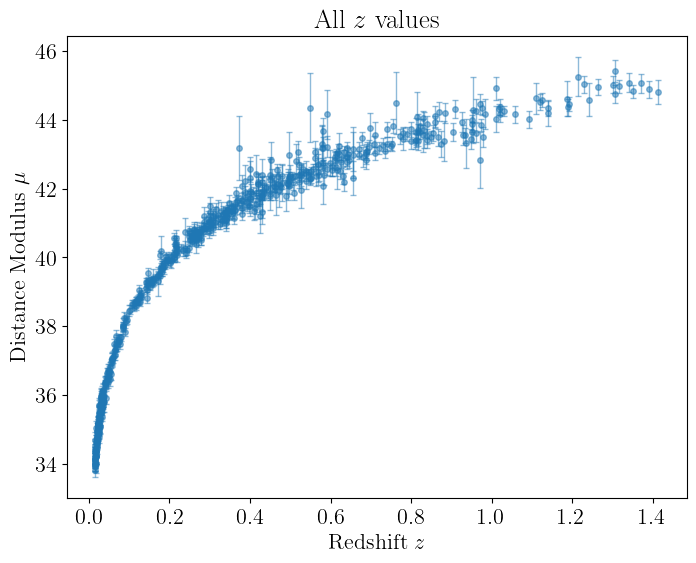

In [5]:
#plt.errorbar(z,mu,yerr=mu_err,color='tab:blue',alpha=0.5)
plt.figure(figsize=(8,6))
plt.errorbar(z,mu,yerr=mu_err,color='tab:blue',alpha=0.5,fmt='o',markersize=4,elinewidth=1,capsize=2)
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\\mu$')
plt.title('All $z$ values')

In [37]:
def mu_to_d(mu):
    return 10**((mu - 25) / 5)  # in Mpc

def d_to_mu(d):
    if all(i <= 0  for i in d) == False:
        mu = 5 * np.log10(d) + 25
    else:
        print(f'MIN DISTANCE: {np.min(d)}')
        raise ValueError("Distance must be positive.")
    return mu

def rho_crit(H):
    return 3 * H**2 / (8 * np.pi * G)

def get_Om_lam(lam,H):
    return lam / (3 * H**2)

def get_Om_M(lam,H,Om_k = None):
    if Om_k is not None:
        return 1 - Om_k - get_Om_lam(lam,H)
    else:
        return 1 - get_Om_lam(lam,H)
    
def get_q0(Om_M,Om_lam):
    return Om_M / 2 - Om_lam

def get_H(H_0,z,q_0):
    
    return H



def E(lam, w = None, H=70,Om_k = None):
    if w is None:
        w = -1
    Om_lam = get_Om_lam(lam,H)
    Om_M = get_Om_M(lam,H,Om_k)
    E = Om_M * (1 + z)**3 + Om_lam * (1 + z)**(3 * (1 + w))
    return E



def model(theta, z):
    lam = theta[0]
    w = theta[1]
    
    z_p = np.linspace(0, z, len(z))
    d = c * (1+z) * np.trapezoid(1 / (lam * E(z_p,lam,w)),z_p)
    mu = d_to_mu(d)
    return mu

In [45]:
def log_likelihood(theta, z, mu, sig_mu):
    '''
    
    z - found in data frame
    mu - found in data frame
    sig_m - found in data frame
    '''
    lam = theta[0]#.flatten()
    w = theta[1]#.flatten()
    sigma2 = 1
    
    s2 = sig_mu**2# + theta[2]**2
    Nd = len(mu)
    weight = 1 / s2 * 1/Nd
    W = np.diag(weight)
    #print(np.max(W))
    y = mu
    mu_model = model(theta,z)
    
    log_like = -0.5 * (y - mu_model).T @ W @ (y - mu_model) + 0.5 * np.linalg.det(W) - Nd * (np.sum(np.log(2 * np.pi * sigma2))/2)

    return log_like#, y[0], model[0]

In [38]:

theta_0 = [0.7,-0.5]
print(log_likelihood(theta_0,z,mu,mu_err))



nan


/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56595/1215495428.py:6: RuntimeWarning: divide by zero encountered in log10
  mu = 5 * np.log10(d) + 25
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56595/3881829140.py:20: RuntimeWarning: invalid value encountered in matmul
  log_like = -0.5 * (y - mu_model).T @ W @ (y - mu_model) + 0.5 * np.linalg.det(W)# - Nd * (np.sum(np.log(2 * np.pi * sigma2))/2)


In [ ]:

#res = scipy.optimize.minimize(log_likelihood, theta_0, args=(z,mu,mu_err))

#print(res)

In [33]:
lam = np.linspace(0,0.7,len(z))
w = np.linspace(-1.5,1.5,len(lam))

lam_grid, wgrid = np.meshgrid(lam,w)

HQ_grid = np.dstack((lam_grid,wgrid))
grid = HQ_grid.reshape(-1,2)

sig = mu_err

#z = unknown_low

n = 0
like = np.zeros((len(w),len(lam)))
sum_like = 0
for q_i,i in zip(w, range(len(w))):
    for H_i,j in zip(lam, range(len(lam))):
        lh = log_likelihood([H_i,q_i,0.5], z, mu, sig)
        like[i,j] = np.exp(lh)


"""post_pdf = np.zeros_like(grid)
for th_idx, th_val in enumerate(H0):
    for s2_idx, s2_val in enumerate(q0):
        post_pdf[s2_idx][th_idx] = log_posterior([th_val,s2_val], z, mu, sig)"""



/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56595/1403654911.py:6: RuntimeWarning: divide by zero encountered in log10
  mu = 5 * np.log10(d) + 25
/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56595/2752807752.py:20: RuntimeWarning: invalid value encountered in matmul
  log_like = -0.5 * (y - mu_model).T @ W @ (y - mu_model) + 0.5 * np.linalg.det(W)# - Nd * (np.sum(np.log(2 * np.pi * sigma2))/2)


KeyboardInterrupt: 

In [ ]:
plt.contourf(lam_grid, wgrid, like, levels=200, cmap='Blues')#,alpha=0.5)
plt.xlabel('$$ [km/s/Mpc]')
plt.ylabel('$q_0$')

/var/folders/xl/schcbct544b8f32_b4484x5c0000gn/T/ipykernel_56595/1215495428.py:6: RuntimeWarning: divide by zero encountered in log10
  mu = 5 * np.log10(d) + 25


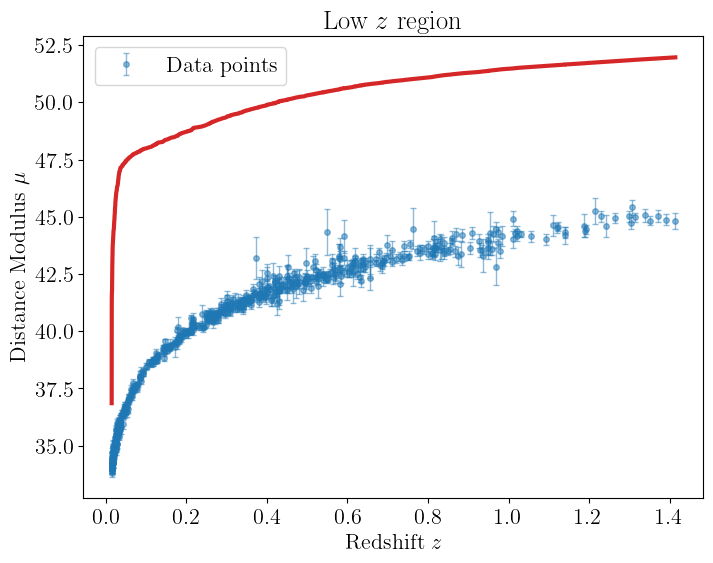

In [47]:
theta_0 = [1,-1]

plt.figure(figsize=(8,6))
plt.errorbar(z,mu,yerr=mu_err,color='tab:blue',alpha=0.5,fmt='o',markersize=4,elinewidth=1,capsize=2,label='Data points')
plt.xlabel('Redshift $z$')
plt.ylabel('Distance Modulus $\\mu$')
plt.title('Low $z$ region')
plt.plot(np.sort(z),model(theta_0,np.sort(z)),color='tab:red',lw = 3)
plt.legend()